In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
from msmbuilder.decomposition import tICA, PCA

In [3]:
dataFull = np.loadtxt('ala4_explicit/COLVAR_md_explicit_10ns')

In [4]:
data = dataFull[:,1:7]
sumabs=dataFull[:,-1]


In [5]:
print(data)
print(sumabs)

[[-2.401463  2.721934 -1.359381  2.476104 -1.271216  2.361919]
 [-2.341986  2.873031 -1.109471  2.587082 -1.49281  -3.125739]
 [-2.458682  2.601563 -1.365601  2.60777  -1.5563    3.084817]
 ...
 [-1.381258  2.279866 -2.30461   3.077384 -1.124621  2.815719]
 [-1.695112  1.912944 -1.793466  2.932431 -1.201032  2.709006]
 [-1.37564   1.898676 -1.830701  2.715888 -0.99448   2.054822]]
[0.758897 0.759956 0.749528 ... 0.463711 0.542259 0.610034]


In [6]:
sincos=[]

for i in range(0,len(data)):
    temp=[]
    for j in range(0,6):
        temp.append(np.sin(data[i,j]))
        temp.append(np.cos(data[i,j]))
    sincos.append(temp)

diheds_sincos=np.array(sincos)

In [7]:
fe = np.loadtxt('ala4_explicit/fe')
print(fe)

[1.397509  1.983793  1.776999  ... 1.375204  0.9172205 1.062112 ]


In [8]:
X = sumabs
X_dihed = diheds_sincos
y = fe

xnew_sincos=[]
xnew=[]
ynew=[]
for i in range(0,len(X)):
    t1=[]
    t1.append(X[i])
    xnew.append(t1)
    t2=[]
    #t2.append(y[i])
    #ynew.append(t2)
    t3=[]
    for j in range(0,12):
        t3.append(X_dihed[i][j])
    xnew_sincos.append(t3)

xnew=np.array(xnew)
#ynew=np.array(ynew)
xnew_sincos=np.array(xnew_sincos)

print(xnew_sincos[0])
sum(xnew_sincos[:,0])

[-0.67438365 -0.73838113  0.40744875 -0.91322807 -0.9777349   0.20984392
  0.61744359 -0.78661516 -0.95546043  0.29511925  0.70304738 -0.71114301]


-41869.03006544425

In [9]:
x_sincos_centered=xnew_sincos

for i in range(0,len(xnew_sincos[0])):
    avg=sum(xnew_sincos[:,i])/len(xnew_sincos)
    print(avg)
    x_sincos_centered[:,i]=x_sincos_centered[:,i]-avg
    
print(x_sincos_centered[0])

-0.8373638540318044
-0.11089574722092439
0.3988736246362931
-0.6151028330760221
-0.8623292715556716
-0.05009631871410182
0.22080465483150075
-0.28863031532459527
-0.8339834437230369
-0.1470649727591676
0.33971750888719676
-0.49980440773681223
[ 0.1629802  -0.62748538  0.00857513 -0.29812524 -0.11540562  0.25994024
  0.39663893 -0.49798485 -0.12147698  0.44218422  0.36332987 -0.21133861]


In [10]:
import sklearn
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sincos_centered, sumabs, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape,y_test.shape )

(40000, 12) (40000,) (10001,)


In [11]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

2.1.0


Using TensorFlow backend.


In [12]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [13]:
original_dim=12
inputs = Input(shape=(original_dim,),name='encoder_input')
latent_dim = 1
batch_size=100
epochs=500

    
x = Dense(6, activation='tanh')(inputs)
x = Dense(3, activation='tanh')(x)
 
z_mean = Dense(latent_dim, activation='tanh',name='z_mean')(x)
z_log_var = Dense(latent_dim,activation='tanh', name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
 
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
    
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(3, activation='tanh')(latent_inputs)
x = Dense(6, activation='tanh')(x)
outputs = Dense(original_dim,activation='tanh')(x)
        
        
    
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 12)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6)            78          encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            21          dense_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 1)            4           dense_2[0][0]                    
____________________________________________________________________________________________

In [14]:

models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()





Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12)                0         
_________________________________________________________________
encoder (Model)              [(None, 1), (None, 1), (N 107       
_________________________________________________________________
decoder (Model)              (None, 12)                114       
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


/Users/navya/anaconda3/envs/msm_env/lib/python2.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [15]:
autoencoder_train=vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_explicit-1dz.h5')

Train on 40000 samples, validate on 10001 samples
Epoch 1/500
40000/40000 [==============================] - 1s 23us/step - loss: 2.8540 - val_loss: 2.7377
Epoch 2/500
40000/40000 [==============================] - 1s 16us/step - loss: 2.7147 - val_loss: 2.7157
Epoch 3/500
40000/40000 [==============================] - 1s 16us/step - loss: 2.7002 - val_loss: 2.7127
Epoch 4/500
40000/40000 [==============================] - 1s 15us/step - loss: 2.6900 - val_loss: 2.6990
Epoch 5/500
40000/40000 [==============================] - 1s 15us/step - loss: 2.6859 - val_loss: 2.6911
Epoch 6/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6851 - val_loss: 2.6873
Epoch 7/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6781 - val_loss: 2.6909
Epoch 8/500
40000/40000 [==============================] - 1s 16us/step - loss: 2.6770 - val_loss: 2.6888
Epoch 9/500
40000/40000 [==============================] - 1s 16us/step - loss: 2.6839 - val_loss: 2.6

Epoch 77/500
40000/40000 [==============================] - 1s 16us/step - loss: 2.6588 - val_loss: 2.6776
Epoch 78/500
40000/40000 [==============================] - 1s 16us/step - loss: 2.6586 - val_loss: 2.6722
Epoch 79/500
40000/40000 [==============================] - 1s 15us/step - loss: 2.6562 - val_loss: 2.6711
Epoch 80/500
40000/40000 [==============================] - 1s 17us/step - loss: 2.6643 - val_loss: 2.6693
Epoch 81/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6536 - val_loss: 2.6580
Epoch 82/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6574 - val_loss: 2.6696
Epoch 83/500
40000/40000 [==============================] - 1s 16us/step - loss: 2.6622 - val_loss: 2.6556
Epoch 84/500
40000/40000 [==============================] - 1s 15us/step - loss: 2.6609 - val_loss: 2.6570
Epoch 85/500
40000/40000 [==============================] - 1s 15us/step - loss: 2.6649 - val_loss: 2.6745
Epoch 86/500
40000/40000 [===========

Epoch 153/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6571 - val_loss: 2.6612
Epoch 154/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6581 - val_loss: 2.6668
Epoch 155/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6581 - val_loss: 2.6646
Epoch 156/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6613 - val_loss: 2.6573
Epoch 157/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6590 - val_loss: 2.6493
Epoch 158/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6626 - val_loss: 2.6776
Epoch 159/500
40000/40000 [==============================] - 1s 15us/step - loss: 2.6569 - val_loss: 2.6678
Epoch 160/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6554 - val_loss: 2.6642
Epoch 161/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6552 - val_loss: 2.6711
Epoch 162/500
40000/40000 [=

40000/40000 [==============================] - 1s 14us/step - loss: 2.6579 - val_loss: 2.6577
Epoch 229/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6567 - val_loss: 2.6604
Epoch 230/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6616 - val_loss: 2.6443
Epoch 231/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6582 - val_loss: 2.6556
Epoch 232/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6576 - val_loss: 2.6560
Epoch 233/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6565 - val_loss: 2.6591
Epoch 234/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6498 - val_loss: 2.6781
Epoch 235/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6497 - val_loss: 2.6596
Epoch 236/500
40000/40000 [==============================] - 1s 15us/step - loss: 2.6519 - val_loss: 2.6740
Epoch 237/500
40000/40000 [===============

40000/40000 [==============================] - 1s 14us/step - loss: 2.6556 - val_loss: 2.6571
Epoch 304/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6574 - val_loss: 2.6625
Epoch 305/500
40000/40000 [==============================] - 1s 13us/step - loss: 2.6535 - val_loss: 2.6677
Epoch 306/500
40000/40000 [==============================] - 1s 15us/step - loss: 2.6550 - val_loss: 2.6801
Epoch 307/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6572 - val_loss: 2.6697
Epoch 308/500
40000/40000 [==============================] - 1s 13us/step - loss: 2.6523 - val_loss: 2.6665
Epoch 309/500
40000/40000 [==============================] - 1s 16us/step - loss: 2.6568 - val_loss: 2.6608
Epoch 310/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6492 - val_loss: 2.6564
Epoch 311/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6535 - val_loss: 2.6631
Epoch 312/500
40000/40000 [===============

40000/40000 [==============================] - 1s 15us/step - loss: 2.6555 - val_loss: 2.6741
Epoch 379/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6540 - val_loss: 2.6629
Epoch 380/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6586 - val_loss: 2.6624
Epoch 381/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6519 - val_loss: 2.6736
Epoch 382/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6576 - val_loss: 2.6549
Epoch 383/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6574 - val_loss: 2.6648
Epoch 384/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6523 - val_loss: 2.6579
Epoch 385/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6503 - val_loss: 2.6570
Epoch 386/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6559 - val_loss: 2.6601
Epoch 387/500
40000/40000 [===============

Epoch 454/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6518 - val_loss: 2.6567
Epoch 455/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6561 - val_loss: 2.6719
Epoch 456/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6566 - val_loss: 2.6472
Epoch 457/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6499 - val_loss: 2.6555
Epoch 458/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6477 - val_loss: 2.6654
Epoch 459/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6600 - val_loss: 2.6623
Epoch 460/500
40000/40000 [==============================] - 1s 15us/step - loss: 2.6478 - val_loss: 2.6648
Epoch 461/500
40000/40000 [==============================] - 1s 13us/step - loss: 2.6502 - val_loss: 2.6773
Epoch 462/500
40000/40000 [==============================] - 1s 14us/step - loss: 2.6535 - val_loss: 2.6650
Epoch 463/500
40000/40000 [=

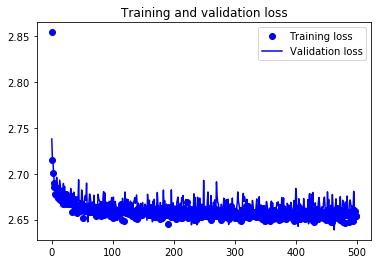

In [16]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'bo', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

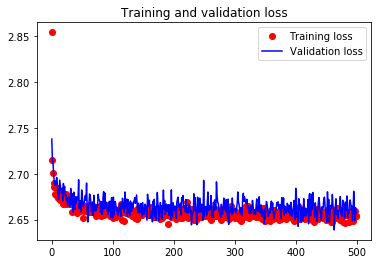

In [17]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
pred = vae.predict(x_test)

In [19]:
pred.shape

(10001, 12)

In [20]:
z_test = encoder.predict(x_test, batch_size=batch_size)

In [21]:
z_test

[array([[ 0.39471206],
        [-0.9991896 ],
        [ 0.3292136 ],
        ...,
        [ 0.41935384],
        [ 0.33943403],
        [-0.99913585]], dtype=float32), array([[-0.96319216],
        [-0.9868669 ],
        [-0.96573436],
        ...,
        [-0.9635782 ],
        [-0.9662735 ],
        [-0.9853987 ]], dtype=float32), array([[ 0.36839658],
        [-0.6470357 ],
        [ 0.0825258 ],
        ...,
        [-0.07780835],
        [-0.33453882],
        [-1.0381802 ]], dtype=float32)]

In [22]:
decoder_test=decoder.predict(z_test[2],batch_size=batch_size)

In [23]:
print(len(decoder_test))

10001


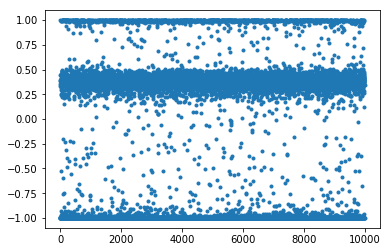

In [41]:
plot(z_test[0],'.')

In [ ]:

scatter(z_test[2][:,0],z_test[2][:,1],c=y_test)
colorbar()

In [46]:
z_train = encoder.predict(x_train, batch_size=batch_size)

In [ ]:
scatter(z_train[0][:,0],z_train[0][:,1],c=y_train)
colorbar()

In [35]:
weights = vae.get_weights()

In [36]:
for i in range(14): print(weights[i].shape)

(12, 6)
(6,)
(6, 3)
(3,)
(3, 1)
(1,)
(3, 1)
(1,)
(1, 3)
(3,)
(3, 6)
(6,)
(6, 12)
(12,)


In [38]:
print(weights[0])

[[ 0.1904502   0.22685203 -0.14407721 -0.1605435   0.13128547 -0.00888695]
 [ 0.16028145  0.16075414 -0.28507045 -0.272482    0.1641806   0.03696314]
 [-0.168653    0.71313256  0.6721668   0.19515765  0.28635606  0.22201273]
 [ 0.83373564 -0.18328714 -1.5513053  -1.8868113   1.2124257   0.03432874]
 [ 0.34034908  0.06778891  0.22044726  0.07885268  0.1032717  -0.02679466]
 [-0.11182279  0.06120566  0.44768292  0.24669169 -0.18361914  0.02365593]
 [-0.5761362  -0.26277915 -0.26899162 -0.9298643   0.53119737 -0.61904556]
 [ 1.473584    1.2141377  -1.014148    0.19023412 -0.7336335   1.1470239 ]
 [ 0.19644515  0.19476183 -0.14151067 -0.07853322 -0.08047556 -0.10724901]
 [-0.08098216 -0.14225495  0.03585443 -0.42139572  0.3592213  -0.19560477]
 [-0.09442071 -0.04733508  0.2287917  -0.06352759  0.04908418 -0.01462075]
 [ 0.29070336  0.16946056 -0.04770342  0.20544234 -0.1792324   0.08020597]]


In [ ]:
first_layer_weights = weights[0]
first_layer_biases  = weights[1]
second_layer_weights = weights[2]
second_layer_biases  = weights[3]
third_layer_weights = weights[4]
third_layer_biases  = weights[5]

In [43]:
np.savetxt('temp',weights[4].T,delimiter=',')

In [78]:
weights[5]

array([-0.0158835], dtype=float32)

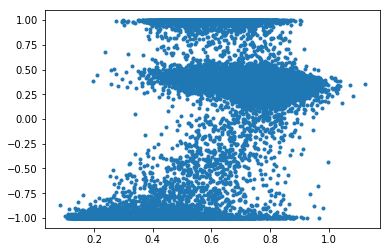

In [49]:
plot(y_train, z_train[0],'.')

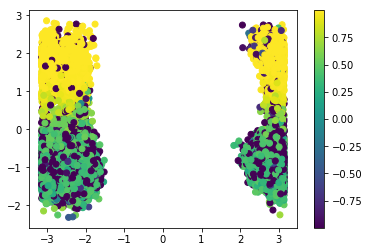

In [69]:
scatter(np.arctan2(x_train[:,1]-0.11089574722092439,x_train[:,0]-0.8373638540318044),np.arctan2(x_train[:,3]
-0.6151028330760221,x_train[:,2]
+ 0.3988736246362931),c=reshape(z_train[0],(40000,)))
colorbar()

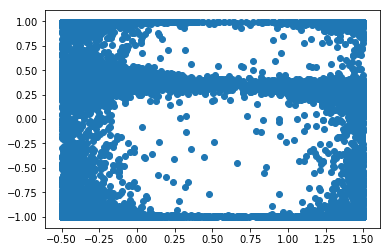

In [76]:
scatter(x_train[:,11],reshape(z_train[0],(40000,)))